## Import modules

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import seaborn as sns

sns.set_palette('cool')

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5)

## Load model data

In [2]:
input_path = '../data/hillslope'
superjunctions = pd.read_csv(f'{input_path}/hillslope_superjunctions.csv')
superlinks = pd.read_csv(f'{input_path}/hillslope_superlinks.csv')

In [3]:
superjunctions

,name,id,z_inv,h_0,bc,storage,a,b,c,max_depth,map_x,map_y
0,0,0,1,0.00001,False,functional,0.0,0.0,200.0,inf,0,0
1,1,1,0,0.00001,False,functional,0.0,0.0,1000.0,inf,1,1


In [4]:
superlinks

,name,id,sj_0,sj_1,in_offset,out_offset,dx,n,shape,g1,g2,g3,g4,Q_0,h_0,ctrl,A_s,A_c,C
0,0,0,0,1,0.0,0.0,1000,0.035,rect_open,10,5,0,0,0,0.00001,False,100,0,0


In [5]:
superlinks['A_s'] = 20.0
superlinks['h_0'] = 1e-2
superjunctions['h_0'] = 1e-2
superlinks['dx'] = 2000.

## 'Ground truth' run

In [6]:
internal_links = 50
superlink = SuperLink(superlinks, superjunctions, internal_links=internal_links)

In [7]:
dt = 120
Q_in = 1.25 * 1e-2 * np.asarray([1., 0.])
Q_0Ik = 1.25 * 1e-3 * np.ones(superlink.NIk) / 2
X = []

while superlink.t < 100000 // 2:
    superlink.step(dt=dt, Q_in=Q_in, Q_0Ik=Q_0Ik)
    x = np.copy(np.concatenate([superlink.H_j[[0]], superlink.h_Ik, superlink.H_j[[-1]],
                                superlink.Q_uk, superlink.Q_ik, superlink.Q_dk]))
    X.append(x)
X = np.vstack(X)

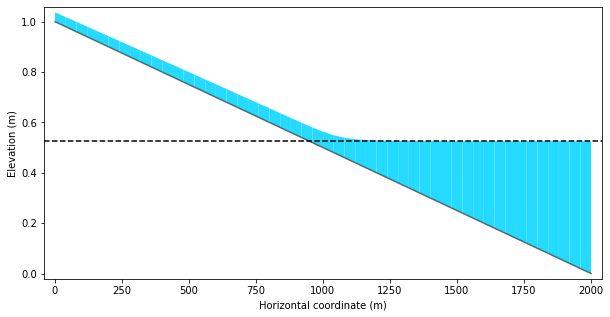

In [8]:
_ = superlink.plot_profile([0, 1])
_ = plt.axhline(superlink.H_j[-1], c='k', linestyle='--')

## Decalibrated run

In [9]:
internal_links = 50
superlink = SuperLink(superlinks, superjunctions, internal_links=internal_links)

In [10]:
Q_in = 0.75 * 1e-2 * np.asarray([1., 0.])
Q_0Ik = 0.75 * 1e-3 * np.ones(superlink.NIk) / 2

In [11]:
X_uncal = []

while superlink.t < 100000 // 2:
    superlink.step(dt=dt, Q_in=Q_in, Q_0Ik=Q_0Ik)
    x = np.copy(np.concatenate([superlink.H_j[[0]], superlink.h_Ik, superlink.H_j[[-1]],
                                superlink.Q_uk, superlink.Q_ik, superlink.Q_dk]))
    X_uncal.append(x)
X_uncal = np.vstack(X_uncal)

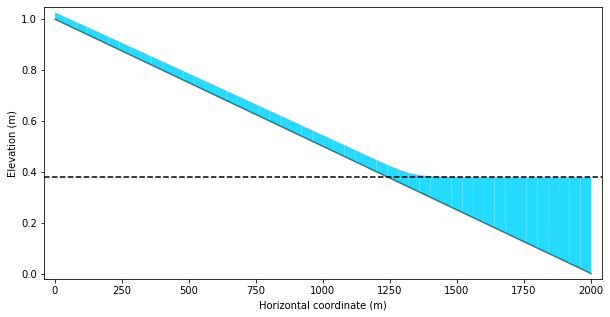

In [12]:
_ = superlink.plot_profile([0, 1])
_ = plt.axhline(superlink.H_j[-1], c='k', linestyle='--')

## Run with Kalman Filtering

In [13]:
internal_links = 50
superlink = SuperLink(superlinks, superjunctions, internal_links=internal_links)

In [14]:
Q_in = 0.75 * 1e-2 * np.asarray([1., 0.])
Q_0Ik = 0.75 * 1e-3 * np.ones(superlink.NIk) / 2

In [15]:
n = superlink._Q_ik.size
N = (2*n + 1) + 4
A_1 = np.zeros((N, N))
A_2 = np.zeros((N, N))
B_1 = np.eye(N)
b = np.zeros(N)
u = np.zeros(N)
Ik = np.arange(n + 1)
ik = np.arange(n)
uk = (n + 1) + 2
dk = N

In [16]:
C = np.zeros((2, N))
ix = 12
C[0, 1 + ix] = 1.
C[1, 1 + (n + 1) + 1 + ix] = 1.

V = 1e-2 * np.eye(len(C))    # Measurement noise
W = 1e-1 * np.eye(N)         # Process noise
S = 1e-2 * np.eye(N)
X_hat = []

In [17]:
X_est = []
gains = []
inc = 0

while superlink.t < 100000 // 2:
    superlink.step(dt=dt, Q_in=Q_in, Q_0Ik=Q_0Ik)
    
    g = 9.81
    _a_ik = superlink._a_ik
    _b_ik = superlink._b_ik
    _c_ik = superlink._c_ik
    _P_ik = superlink._P_ik
    _E_Ik = superlink._E_Ik
    _D_Ik = superlink._D_Ik
    _A_ik = superlink._A_ik
    _B_ik = superlink._B_ik
    _gamma_uk = superlink._kappa_uk
    _gamma_dk = superlink._kappa_dk
    _theta_uk = superlink._theta_uk
    _theta_dk = superlink._theta_dk
    _dx_ik = superlink._dx_ik
    _S_o_ik = superlink._S_o_ik
    H_j_t = superlink.states['H_j']
    
    A_1[0, 0] = superlink._A_sj[0] / dt
    A_1[0, 1 + (n + 1) + 1] = 1.
    A_1[1,0] = _theta_uk
    A_1[1, 1] = -1.
    A_1[1, 1 + (n + 1) + 1] = _gamma_uk
    A_1[2 + Ik, 1 + Ik] = _E_Ik
    A_1[2 + Ik, 1 + (n + 1) + 1 + Ik] = -1.
    A_1[2 + Ik, 1 + (n + 1) + 1 + 1 + Ik] = 1.
    A_1[2 + (n + 1) + ik, 1 + ik] = -g * _A_ik
    A_1[2 + (n + 1) + ik, 2 + ik] = g * _A_ik
    A_1[2 + (n + 1) + ik[1:], 1 + (n + 1) + 1 + 1 + ik[:-1]] = _a_ik[1:]
    A_1[2 + (n + 1) + ik, 1 + (n + 1) + 1 + 1 + ik] = _b_ik
    A_1[2 + (n + 1) + ik[:-1], 1 + (n + 1) + 1 + 1 + ik[1:]] = _c_ik[:-1]
    A_1[-2, 1 + n] = -1.
    A_1[-2, 1 + (n + 1)] = _theta_dk
    A_1[-2, -1] = _gamma_dk
    A_1[-1, 1 + (n + 1)] = superlink._A_sj[-1] / dt
    A_1[-1, -1] = -1.
    
    A_2[0, 0] = (superlink._A_sj[0] / dt)
    A_2[1, 0] = 0.
    A_2[2 + Ik, 1 + Ik] = _E_Ik
    A_2[2 + (n + 1) + ik, 1 + (n + 1) + 1 + 1 + ik] = _dx_ik / dt
    A_2[2 + (n + 1) + ik, 1 + ik] = g * _S_o_ik * _dx_ik * (0.5 * _B_ik)
    A_2[2 + (n + 1) + ik, 2 + ik] = g * _S_o_ik * _dx_ik * (0.5 * _B_ik)
    A_2[-1, 1 + (n + 1)] = superlink._A_sj[-1] / dt
    
    u[0] = Q_in[0]
    u[1] = _theta_uk * superlink._z_inv_uk[0]
    u[2 + Ik] = Q_0Ik
    u[-2] = _theta_dk * superlink._z_inv_dk[0]
    u[-1] = Q_in[-1]
    
    A_1_inv = np.linalg.inv(A_1)
    A = A_1_inv @ A_2
    B = A_1_inv @ B_1
    
    x_prev = np.concatenate([superlink.states['H_j'][[0]], superlink.states['h_Ik'],
                             superlink.states['H_j'][[-1]], superlink.states['Q_uk'], 
                             superlink.states['Q_ik'], superlink.states['Q_dk']])
    
    y = C @ X[inc]
    S = A @ (S - S @ C.T @ np.linalg.inv(C @ S @ C.T + V) @ C @ S) @ A.T + W
    L = S @ C.T @ np.linalg.inv(C @ S @ C.T + V)
    y_hat = C @ (A @ x_prev + B @ u)
    x_next = A @ x_prev + B @ u + L @ (y - y_hat)
    gain = L @ (y - y_hat)
    
    superlink.H_j[0] = x_next[0]
    superlink.H_j[-1] = x_next[1 + (n + 1)]
    superlink._h_Ik[:] = x_next[1:1 + (n + 1)]
    superlink._Q_uk[:] = x_next[1 + (n + 1) + 1]
    superlink._Q_ik[:] = x_next[1 + (n + 1) + 1 + 1:-1]
    superlink._Q_dk[:] = x_next[-1]
    
    gains.append(gain)
    X_est.append(np.copy(x_next))
    
    inc += 1
    
gains = np.vstack(gains)
X_est = np.vstack(X_est)
time_range = dt * np.arange(len(X)) / 3600

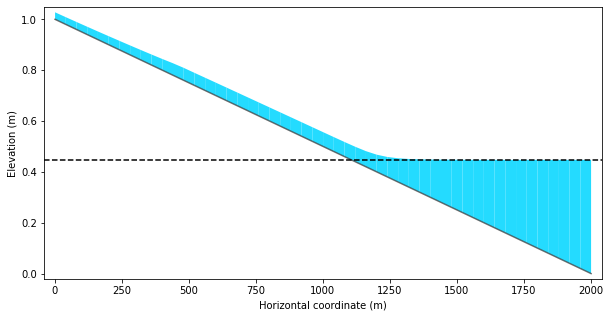

In [18]:
_ = superlink.plot_profile([0, 1])
_ = plt.axhline(superlink.H_j[-1], c='k', linestyle='--')

In [19]:
sns.set_palette('tab10')

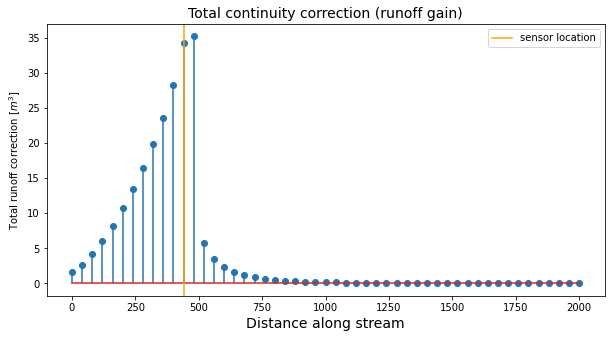

In [20]:
plt.stem(superlink._x_Ik, dt * gains[:, 1:1 + (n + 1)].sum(axis=0))
plt.axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
plt.title('Total continuity correction (runoff gain)', size=14)
plt.xlabel('Distance along stream', size=14)
plt.ylabel('Total runoff correction [$m^3$]')
_ = plt.legend()

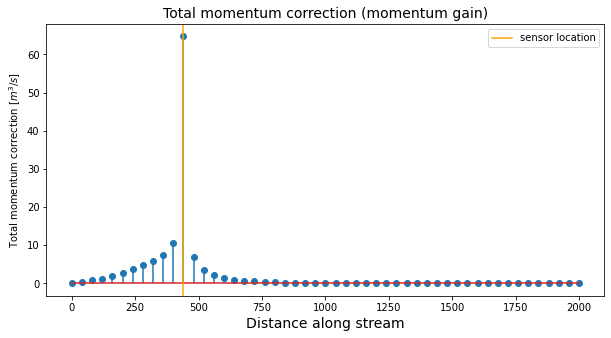

In [21]:
plt.stem(superlink._x_Ik, dt * gains[:, 1 + (n + 1) + 1 + 1:].sum(axis=0))
plt.axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
plt.title('Total momentum correction (momentum gain)', size=14)
plt.xlabel('Distance along stream', size=14)
plt.ylabel('Total momentum correction [$m^3 / s$]')
_ = plt.legend()

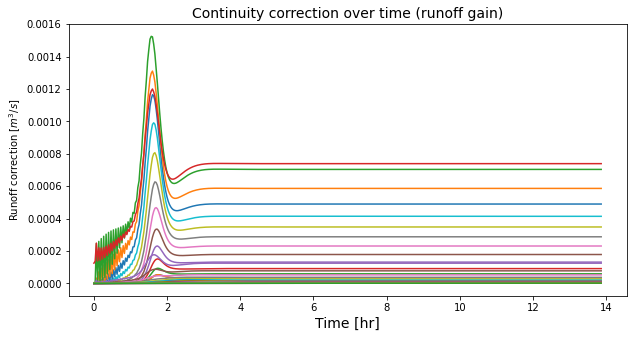

In [22]:
_ = plt.plot(time_range, gains[:, :1 + (n + 1) + 1])
plt.title('Continuity correction over time (runoff gain)', size=14)
plt.xlabel('Time [hr]', size=14)
_ = plt.ylabel('Runoff correction [$m^3 / s$]')

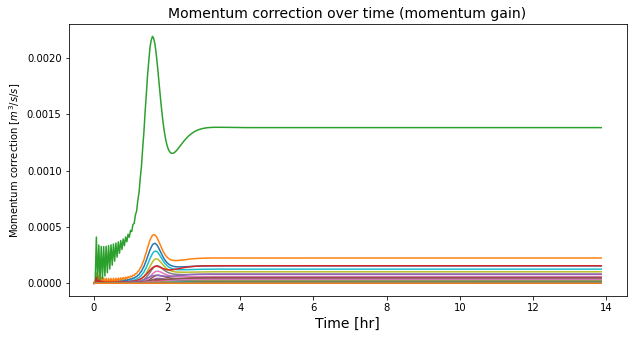

In [23]:
_ = plt.plot(time_range, gains[:, 1 + (n + 1) + 1:])
plt.title('Momentum correction over time (momentum gain)', size=14)
plt.xlabel('Time [hr]', size=14)
_ = plt.ylabel('Momentum correction [$m^3 / s / s$]')

In [24]:
sns.set_palette('cool')

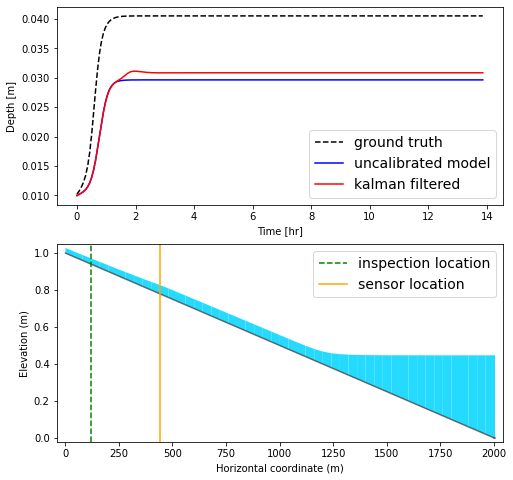

In [25]:
elem = 4

fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(time_range, X[:,elem], c='k', linestyle='--', label='ground truth')
ax[0].plot(time_range, X_uncal[:,elem], c='b', label='uncalibrated model')
ax[0].plot(time_range, X_est[:,elem], c='r', label='kalman filtered')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Time [hr]')
ax[0].legend(fontsize=14)

_ = superlink.plot_profile([0, 1], ax=ax[1])
ax[1].axvline(superlink._x_Ik[elem - 1], c='green', linestyle='--', label='inspection location')
ax[1].axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
_ = ax[1].legend(fontsize=14)

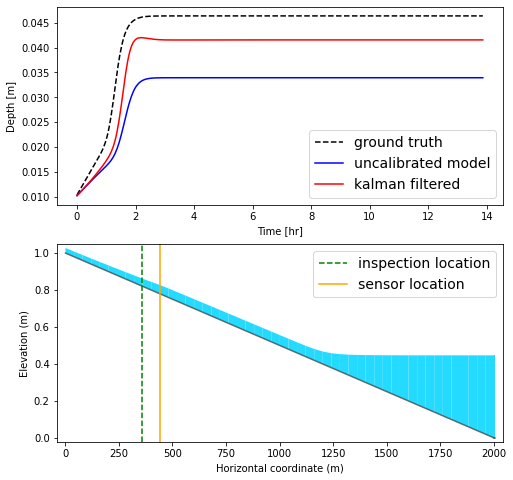

In [26]:
elem = 10

fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(time_range, X[:,elem], c='k', linestyle='--', label='ground truth')
ax[0].plot(time_range, X_uncal[:,elem], c='b', label='uncalibrated model')
ax[0].plot(time_range, X_est[:,elem], c='r', label='kalman filtered')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Time [hr]')
ax[0].legend(fontsize=14)

_ = superlink.plot_profile([0, 1], ax=ax[1])
ax[1].axvline(superlink._x_Ik[elem - 1], c='green', linestyle='--', label='inspection location')
ax[1].axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
_ = ax[1].legend(fontsize=14)

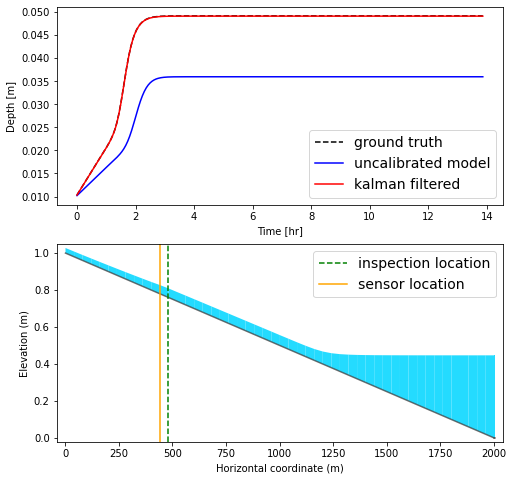

In [27]:
elem = 13

fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(time_range, X[:,elem], c='k', linestyle='--', label='ground truth')
ax[0].plot(time_range, X_uncal[:,elem], c='b', label='uncalibrated model')
ax[0].plot(time_range, X_est[:,elem], c='r', label='kalman filtered')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Time [hr]')
ax[0].legend(fontsize=14)

_ = superlink.plot_profile([0, 1], ax=ax[1])
ax[1].axvline(superlink._x_Ik[elem - 1], c='green', linestyle='--', label='inspection location')
ax[1].axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
_ = ax[1].legend(fontsize=14)

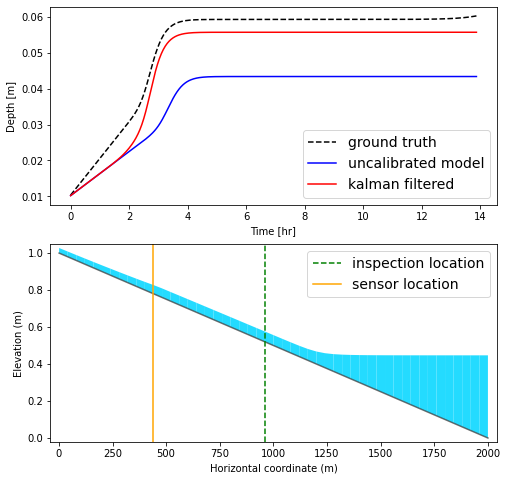

In [28]:
elem = 25

fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(time_range, X[:,elem], c='k', linestyle='--', label='ground truth')
ax[0].plot(time_range, X_uncal[:,elem], c='b', label='uncalibrated model')
ax[0].plot(time_range, X_est[:,elem], c='r', label='kalman filtered')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Time [hr]')
ax[0].legend(fontsize=14)

_ = superlink.plot_profile([0, 1], ax=ax[1])
ax[1].axvline(superlink._x_Ik[elem - 1], c='green', linestyle='--', label='inspection location')
ax[1].axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
_ = ax[1].legend(fontsize=14)

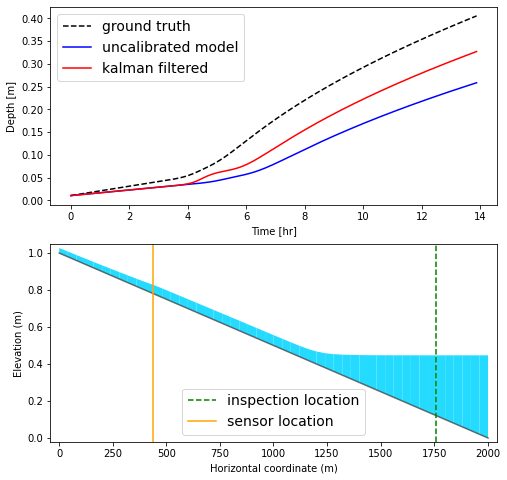

In [29]:
elem = 45

fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(time_range, X[:,elem], c='k', linestyle='--', label='ground truth')
ax[0].plot(time_range, X_uncal[:,elem], c='b', label='uncalibrated model')
ax[0].plot(time_range, X_est[:,elem], c='r', label='kalman filtered')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Time [hr]')
ax[0].legend(fontsize=14)

_ = superlink.plot_profile([0, 1], ax=ax[1])
ax[1].axvline(superlink._x_Ik[elem - 1], c='green', linestyle='--', label='inspection location')
ax[1].axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
_ = ax[1].legend(fontsize=14)

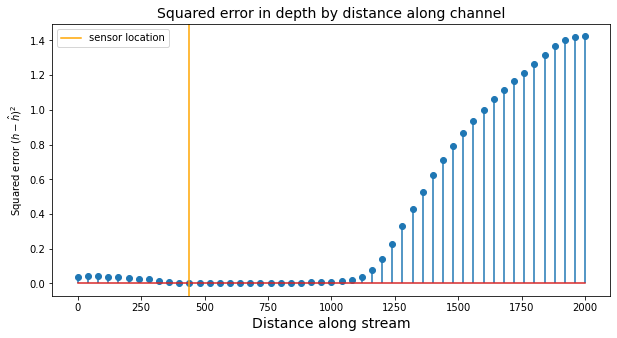

In [30]:
sns.set_palette('tab10')
plt.stem(superlink._x_Ik, ((X - X_est)**2).sum(axis=0)[1:1 + (n + 1)])
plt.axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
plt.title('Squared error in depth by distance along channel', size=14)
plt.ylabel('Squared error $(h - \hat{h})^2$')
plt.xlabel('Distance along stream', size=14)
_ = plt.legend()

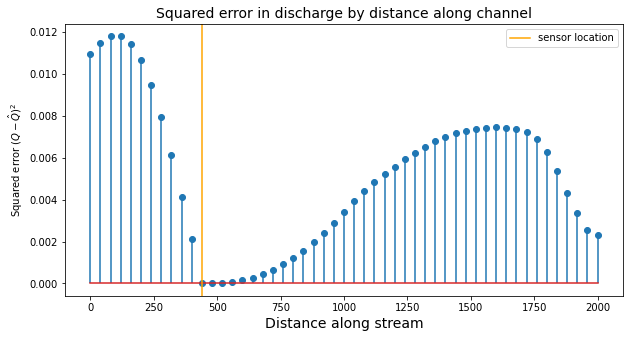

In [31]:
sns.set_palette('tab10')
plt.stem(superlink._x_Ik, ((X - X_est)**2).sum(axis=0)[1 + (n + 1) + 1 + 1:])
plt.axvline(superlink._x_Ik[ix - 1], c='orange', linestyle='-', label='sensor location')
plt.title('Squared error in discharge by distance along channel', size=14)
plt.ylabel('Squared error $(Q - \hat{Q})^2$')
plt.xlabel('Distance along stream', size=14)
_ = plt.legend()